In [1]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import scipy.stats as stats

import sys

In [2]:
# Set the maximum width of the display
pd.set_option('display.width', 1000)

# Set the maximum number of columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 30)

pd.set_option('display.precision', 2)

In [3]:
# fetch dataset
data = fetch_ucirepo(id=374)

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data=data.data.features)

re_express = r'(\d{4})-(\d{2})-(\d{2})(\d{2}):(\d{2}):(\d{2})'

# Replace using the pattern
df['date'] = df['date'].str.replace(re_express, r'\1-\2-\3 \4:\5:\6', regex=True)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S", errors='raise')

# df['date'] = pd.date_range(start='2016-01-11 17:00:00', end='2016-05-27 18:00:00', freq='10min')

# If the data has target labels, you can also add them to the DataFrame
df['target'] = data.data.targets

# add ID as column
df['ID'] = np.arange(1, len(df) + 1, 1)

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Optionally, sort the DataFrame by the new datetime index
df.sort_index(inplace=True)

# since we sort the dataframe by the new datetime index
# df = df.reset_index()

# Display the first few rows of the DataFrame
df.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,target,ID
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,19.89,47.60,19.2,44.79,19.79,44.73,19.00,45.57,17.17,55.20,7.03,84.26,17.20,41.63,18.2,48.90,17.03,45.53,6.60,733.5,92.0,7.00,63.00,5.3,13.28,13.28,60,1
2016-01-11 17:10:00,30,19.89,46.69,19.2,44.72,19.79,44.79,19.00,45.99,17.17,55.20,6.83,84.06,17.20,41.56,18.2,48.86,17.07,45.56,6.48,733.6,92.0,6.67,59.17,5.2,18.61,18.61,60,2
2016-01-11 17:20:00,30,19.89,46.30,19.2,44.63,19.79,44.93,18.93,45.89,17.17,55.09,6.56,83.16,17.20,41.43,18.2,48.73,17.00,45.50,6.37,733.7,92.0,6.33,55.33,5.1,28.64,28.64,50,3
2016-01-11 17:30:00,40,19.89,46.07,19.2,44.59,19.79,45.00,18.89,45.72,17.17,55.09,6.43,83.42,17.13,41.29,18.1,48.59,17.00,45.40,6.25,733.8,92.0,6.00,51.50,5.0,45.41,45.41,50,4
2016-01-11 17:40:00,40,19.89,46.33,19.2,44.53,19.79,45.00,18.89,45.53,17.20,55.09,6.37,84.89,17.20,41.23,18.1,48.59,17.00,45.40,6.13,733.9,92.0,5.67,47.67,4.9,10.08,10.08,60,5


We are creating three diferent class: 

1. MultiLagFeature
2. SineTransformer
3. CosineTransformer

In [4]:
# https://sklearn-template.readthedocs.io/en/latest/user_guide.html

from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.compose import ColumnTransformer

# Custom transformer to create multiple lags
class MultiLagFeature(BaseEstimator, TransformerMixin):
    def __init__(self, max_lag: int = 10):
        self.max_lag = max_lag
        self.column = None
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.column = X.columns  # Set column name from the DataFrame
        else:
            raise ValueError("Input must be a pandas DataFrame")
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        
        if self.column is None:
            raise ValueError("Column name not set. Make sure to call fit before transform.")
        
        # Create a list to hold lagged DataFrames
        lagged_frames = []
        
        for column in self.column:
            # For each column, create lagged features and store them in a DataFrame
            lagged_data = pd.DataFrame({
                f'{column}_lag{lag}': X[column].shift(lag)
                for lag in range(1, self.max_lag + 1)
            })
            lagged_frames.append(lagged_data)
        
        # Concatenate all lagged DataFrames with the original DataFrame
        X_lagged = pd.concat([X] + lagged_frames, axis=1)
        self.feature_names_ = X_lagged.columns
        return X_lagged
    
    def get_feature_names_out(self, *args, **params):
        return self.feature_names_
    

class SineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, season_length: list[int] = 1):
        self.column = None
        self.season_length = [season_length] if isinstance(season_length, int) else season_length
        self.feature_names_ = None
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.column = X.columns  # Set column name from the DataFrame
        else:
            raise ValueError("Input must be a pandas DataFrame")
        return self
    
    def transform(self, X):
        vector_names = [f'Sine_{length}' for length in self.season_length]
        W = pd.DataFrame(columns=vector_names, index=X.index)
        for column in self.column:
            for season in self.season_length:
                W[f'Sine_{season}'] = np.sin(2 * np.pi * X[column] * (1/season))
        self.feature_names_ = W.columns
        return W
    
    def get_feature_names_out(self, *args, **params):
        return self.feature_names_

class CosineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, season_length: list[int] = 1):
        self.column = None
        self.season_length = [season_length] if isinstance(season_length, int) else season_length
        self.feature_names_ = None
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.column = X.columns  # Set column name from the DataFrame
        else:
            raise ValueError("Input must be a pandas DataFrame")
        return self
    
    def transform(self, X):
        vector_names = [f'Cosine_{length}' for length in self.season_length]
        W = pd.DataFrame(columns=vector_names, index=X.index)
        for column in self.column:
            for season in self.season_length:
                W[f'Cosine_{season}'] = np.cos(2 * np.pi * X[column] * (1/season))
        self.feature_names_ = W.columns
        return W
    
    def get_feature_names_out(self, *args, **params):
        return self.feature_names_


##### I will use 'RH_out' because it has the highest correlation (Cross-correlation.ipynb) over time compared to the others.

I conducted some experiments before finding these values for the max_lag, and they turned out to be excellent for capturing the higher peaks in the target time series.

In [5]:

trip_distance_trans = ColumnTransformer(
    transformers=[
        ("trans",  MultiLagFeature(max_lag=432), ['RH_out']), # three days before
        ("target",  MultiLagFeature(max_lag=720), ['target']), # five days before
        ('Sin', SineTransformer(season_length = 144), ['ID'] ),
        ('Cos', CosineTransformer(season_length = 144), ['ID'])
    ],
    # remainder='passthrough'
).set_output(transform='pandas')

In [6]:
trip_distance_trans

ColumnTransformer(transformers=[('trans', MultiLagFeature(max_lag=432),
                                 ['RH_out']),
                                ('target', MultiLagFeature(max_lag=720),
                                 ['target']),
                                ('Sin', SineTransformer(season_length=[144]),
                                 ['ID']),
                                ('Cos', CosineTransformer(season_length=[144]),
                                 ['ID'])])

In [7]:
Q = trip_distance_trans.fit_transform(df)
Q.head()

,trans__RH_out,trans__RH_out_lag1,trans__RH_out_lag2,trans__RH_out_lag3,trans__RH_out_lag4,trans__RH_out_lag5,trans__RH_out_lag6,trans__RH_out_lag7,trans__RH_out_lag8,trans__RH_out_lag9,trans__RH_out_lag10,trans__RH_out_lag11,trans__RH_out_lag12,trans__RH_out_lag13,trans__RH_out_lag14,trans__RH_out_lag15,trans__RH_out_lag16,trans__RH_out_lag17,trans__RH_out_lag18,trans__RH_out_lag19,trans__RH_out_lag20,trans__RH_out_lag21,trans__RH_out_lag22,trans__RH_out_lag23,trans__RH_out_lag24,trans__RH_out_lag25,trans__RH_out_lag26,trans__RH_out_lag27,trans__RH_out_lag28,trans__RH_out_lag29,trans__RH_out_lag30,trans__RH_out_lag31,trans__RH_out_lag32,trans__RH_out_lag33,trans__RH_out_lag34,trans__RH_out_lag35,trans__RH_out_lag36,trans__RH_out_lag37,trans__RH_out_lag38,trans__RH_out_lag39,trans__RH_out_lag40,trans__RH_out_lag41,trans__RH_out_lag42,trans__RH_out_lag43,trans__RH_out_lag44,trans__RH_out_lag45,trans__RH_out_lag46,trans__RH_out_lag47,trans__RH_out_lag48,trans__RH_out_lag49,trans__RH_out_lag50,trans__RH_out_lag51,trans__RH_out_lag52,trans__RH_out_lag53,trans__RH_out_lag54,trans__RH_out_lag55,trans__RH_out_lag56,trans__RH_out_lag57,trans__RH_out_lag58,trans__RH_out_lag59,trans__RH_out_lag60,trans__RH_out_lag61,trans__RH_out_lag62,trans__RH_out_lag63,trans__RH_out_lag64,trans__RH_out_lag65,trans__RH_out_lag66,trans__RH_out_lag67,trans__RH_out_lag68,trans__RH_out_lag69,trans__RH_out_lag70,trans__RH_out_lag71,trans__RH_out_lag72,trans__RH_out_lag73,trans__RH_out_lag74,trans__RH_out_lag75,trans__RH_out_lag76,trans__RH_out_lag77,trans__RH_out_lag78,trans__RH_out_lag79,trans__RH_out_lag80,trans__RH_out_lag81,trans__RH_out_lag82,trans__RH_out_lag83,trans__RH_out_lag84,trans__RH_out_lag85,trans__RH_out_lag86,trans__RH_out_lag87,trans__RH_out_lag88,trans__RH_out_lag89,trans__RH_out_lag90,trans__RH_out_lag91,trans__RH_out_lag92,trans__RH_out_lag93,trans__RH_out_lag94,trans__RH_out_lag95,trans__RH_out_lag96,trans__RH_out_lag97,trans__RH_out_lag98,trans__RH_out_lag99,trans__RH_out_lag100,trans__RH_out_lag101,trans__RH_out_lag102,trans__RH_out_lag103,trans__RH_out_lag104,trans__RH_out_lag105,trans__RH_out_lag106,trans__RH_out_lag107,trans__RH_out_lag108,trans__RH_out_lag109,trans__RH_out_lag110,trans__RH_out_lag111,trans__RH_out_lag112,trans__RH_out_lag113,trans__RH_out_lag114,trans__RH_out_lag115,trans__RH_out_lag116,trans__RH_out_lag117,trans__RH_out_lag118,trans__RH_out_lag119,trans__RH_out_lag120,trans__RH_out_lag121,trans__RH_out_lag122,trans__RH_out_lag123,trans__RH_out_lag124,trans__RH_out_lag125,trans__RH_out_lag126,trans__RH_out_lag127,trans__RH_out_lag128,trans__RH_out_lag129,trans__RH_out_lag130,trans__RH_out_lag131,trans__RH_out_lag132,trans__RH_out_lag133,trans__RH_out_lag134,trans__RH_out_lag135,trans__RH_out_lag136,trans__RH_out_lag137,trans__RH_out_lag138,trans__RH_out_lag139,trans__RH_out_lag140,trans__RH_out_lag141,trans__RH_out_lag142,trans__RH_out_lag143,trans__RH_out_lag144,trans__RH_out_lag145,trans__RH_out_lag146,trans__RH_out_lag147,trans__RH_out_lag148,trans__RH_out_lag149,trans__RH_out_lag150,trans__RH_out_lag151,trans__RH_out_lag152,trans__RH_out_lag153,trans__RH_out_lag154,trans__RH_out_lag155,trans__RH_out_lag156,trans__RH_out_lag157,trans__RH_out_lag158,trans__RH_out_lag159,trans__RH_out_lag160,trans__RH_out_lag161,trans__RH_out_lag162,trans__RH_out_lag163,trans__RH_out_lag164,trans__RH_out_lag165,trans__RH_out_lag166,trans__RH_out_lag167,trans__RH_out_lag168,trans__RH_out_lag169,trans__RH_out_lag170,trans__RH_out_lag171,trans__RH_out_lag172,trans__RH_out_lag173,trans__RH_out_lag174,trans__RH_out_lag175,trans__RH_out_lag176,trans__RH_out_lag177,trans__RH_out_lag178,trans__RH_out_lag179,trans__RH_out_lag180,trans__RH_out_lag181,trans__RH_out_lag182,trans__RH_out_lag183,trans__RH_out_lag184,trans__RH_out_lag185,trans__RH_out_lag186,trans__RH_out_lag187,trans__RH_out_lag188,trans__RH_out_lag189,trans__RH_out_lag190,trans__RH_out_lag191,trans__RH_out_lag192,trans__RH_out_lag193,trans__RH_out_lag194,trans__RH_out_lag19

 #### grid search has exhausted all the combinations

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
Q_cleaned = Q.dropna()
Q_cleaned.head()

,trans__RH_out,trans__RH_out_lag1,trans__RH_out_lag2,trans__RH_out_lag3,trans__RH_out_lag4,trans__RH_out_lag5,trans__RH_out_lag6,trans__RH_out_lag7,trans__RH_out_lag8,trans__RH_out_lag9,trans__RH_out_lag10,trans__RH_out_lag11,trans__RH_out_lag12,trans__RH_out_lag13,trans__RH_out_lag14,trans__RH_out_lag15,trans__RH_out_lag16,trans__RH_out_lag17,trans__RH_out_lag18,trans__RH_out_lag19,trans__RH_out_lag20,trans__RH_out_lag21,trans__RH_out_lag22,trans__RH_out_lag23,trans__RH_out_lag24,trans__RH_out_lag25,trans__RH_out_lag26,trans__RH_out_lag27,trans__RH_out_lag28,trans__RH_out_lag29,trans__RH_out_lag30,trans__RH_out_lag31,trans__RH_out_lag32,trans__RH_out_lag33,trans__RH_out_lag34,trans__RH_out_lag35,trans__RH_out_lag36,trans__RH_out_lag37,trans__RH_out_lag38,trans__RH_out_lag39,trans__RH_out_lag40,trans__RH_out_lag41,trans__RH_out_lag42,trans__RH_out_lag43,trans__RH_out_lag44,trans__RH_out_lag45,trans__RH_out_lag46,trans__RH_out_lag47,trans__RH_out_lag48,trans__RH_out_lag49,trans__RH_out_lag50,trans__RH_out_lag51,trans__RH_out_lag52,trans__RH_out_lag53,trans__RH_out_lag54,trans__RH_out_lag55,trans__RH_out_lag56,trans__RH_out_lag57,trans__RH_out_lag58,trans__RH_out_lag59,trans__RH_out_lag60,trans__RH_out_lag61,trans__RH_out_lag62,trans__RH_out_lag63,trans__RH_out_lag64,trans__RH_out_lag65,trans__RH_out_lag66,trans__RH_out_lag67,trans__RH_out_lag68,trans__RH_out_lag69,trans__RH_out_lag70,trans__RH_out_lag71,trans__RH_out_lag72,trans__RH_out_lag73,trans__RH_out_lag74,trans__RH_out_lag75,trans__RH_out_lag76,trans__RH_out_lag77,trans__RH_out_lag78,trans__RH_out_lag79,trans__RH_out_lag80,trans__RH_out_lag81,trans__RH_out_lag82,trans__RH_out_lag83,trans__RH_out_lag84,trans__RH_out_lag85,trans__RH_out_lag86,trans__RH_out_lag87,trans__RH_out_lag88,trans__RH_out_lag89,trans__RH_out_lag90,trans__RH_out_lag91,trans__RH_out_lag92,trans__RH_out_lag93,trans__RH_out_lag94,trans__RH_out_lag95,trans__RH_out_lag96,trans__RH_out_lag97,trans__RH_out_lag98,trans__RH_out_lag99,trans__RH_out_lag100,trans__RH_out_lag101,trans__RH_out_lag102,trans__RH_out_lag103,trans__RH_out_lag104,trans__RH_out_lag105,trans__RH_out_lag106,trans__RH_out_lag107,trans__RH_out_lag108,trans__RH_out_lag109,trans__RH_out_lag110,trans__RH_out_lag111,trans__RH_out_lag112,trans__RH_out_lag113,trans__RH_out_lag114,trans__RH_out_lag115,trans__RH_out_lag116,trans__RH_out_lag117,trans__RH_out_lag118,trans__RH_out_lag119,trans__RH_out_lag120,trans__RH_out_lag121,trans__RH_out_lag122,trans__RH_out_lag123,trans__RH_out_lag124,trans__RH_out_lag125,trans__RH_out_lag126,trans__RH_out_lag127,trans__RH_out_lag128,trans__RH_out_lag129,trans__RH_out_lag130,trans__RH_out_lag131,trans__RH_out_lag132,trans__RH_out_lag133,trans__RH_out_lag134,trans__RH_out_lag135,trans__RH_out_lag136,trans__RH_out_lag137,trans__RH_out_lag138,trans__RH_out_lag139,trans__RH_out_lag140,trans__RH_out_lag141,trans__RH_out_lag142,trans__RH_out_lag143,trans__RH_out_lag144,trans__RH_out_lag145,trans__RH_out_lag146,trans__RH_out_lag147,trans__RH_out_lag148,trans__RH_out_lag149,trans__RH_out_lag150,trans__RH_out_lag151,trans__RH_out_lag152,trans__RH_out_lag153,trans__RH_out_lag154,trans__RH_out_lag155,trans__RH_out_lag156,trans__RH_out_lag157,trans__RH_out_lag158,trans__RH_out_lag159,trans__RH_out_lag160,trans__RH_out_lag161,trans__RH_out_lag162,trans__RH_out_lag163,trans__RH_out_lag164,trans__RH_out_lag165,trans__RH_out_lag166,trans__RH_out_lag167,trans__RH_out_lag168,trans__RH_out_lag169,trans__RH_out_lag170,trans__RH_out_lag171,trans__RH_out_lag172,trans__RH_out_lag173,trans__RH_out_lag174,trans__RH_out_lag175,trans__RH_out_lag176,trans__RH_out_lag177,trans__RH_out_lag178,trans__RH_out_lag179,trans__RH_out_lag180,trans__RH_out_lag181,trans__RH_out_lag182,trans__RH_out_lag183,trans__RH_out_lag184,trans__RH_out_lag185,trans__RH_out_lag186,trans__RH_out_lag187,trans__RH_out_lag188,trans__RH_out_lag189,trans__RH_out_lag190,trans__RH_out_lag191,trans__RH_out_lag192,trans__RH_out_lag193,trans__RH_out_lag194,trans__RH_out_lag19

#### We will confirm if the timeline remains the same after managing our dataset.

In [10]:
# Compare the full range with the current index

full_range = pd.date_range(start=Q_cleaned.index.min(), end=Q_cleaned.index.max(), freq='10min')

missing_dates = full_range.difference(Q_cleaned.index)

if missing_dates.empty:
    print("The index is continuous with no missing dates.")
else:
    print("The index has breaks in the following dates:")
    print(missing_dates)

The index is continuous with no missing dates.


In [11]:
X = Q_cleaned.drop('target__target', axis=1)
y = Q_cleaned['target__target']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

len(X_train), len(y_train), len(X_test), len(y_test)

(13310, 13310, 5705, 5705)

In [13]:
import xgboost as xgb

from hyperopt import (
    fmin,  # Function for minimizing/maximizing an objective function
    tpe,   # Tree-structured Parzen Estimator (TPE) algorithm for optimization
    hp,    # Defines search space for hyperparameters
    STATUS_OK,  # Constant indicating successful completion of an objective
    Trials  # Container for storing results of each trial
)


from hyperopt.pyll import scope # Handles scoping in hyperparameter definitions
from hyperopt.pyll.stochastic import sample
from hyperopt.early_stop import no_progress_loss

from sklearn.model_selection import TimeSeriesSplit

# Show all messages, including ones pertaining to debugging
xgb.set_config(verbosity=2)

import warnings
warnings.filterwarnings("ignore")

In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=False)
dtest = xgb.DMatrix(X_test,   label=y_test,  enable_categorical=False)

model = xgb.XGBRegressor(verbosity=0, booster = 'gbtree')
print(model)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [15]:
# model.get_xgb_params()
# model.get_params()

##### We decided to use Tweedie regression because it guarantees that the predicted values will always be positive and offers a special case:

* tweedie_variance_power: range: (1,2)

    * Set closer to 2 to shift towards a gamma distribution
    * Set closer to 1 to shift towards a Poisson distribution.

In [16]:
# https://xgboost.readthedocs.io/en/release_0.90/parameter.html
# https://xgboost.readthedocs.io/en/release_0.90/tutorials/param_tuning.html

search_space = {
    'booster': hp.choice('booster', ['gblinear', 'gbtree']),
    'objective': 'reg:tweedie',
    'eval_metric': 'tweedie-nloglik',
    'tweedie_variance_power': hp.uniform("tweedie_variance_power", 1, 2),
    'learning_rate': hp.uniform("learning_rate", 0, 1),
    'gamma': hp.uniform("gamma", 0, 10e1),
    'max_depth': hp.choice('max_depth', np.arange(1, 100, dtype=int)),
    'min_child_weight': hp.choice("min_child_weight", np.arange(1,10,1, dtype=int)),
    'max_delta_step': hp.choice("max_delta_step", np.arange(1,10,1, dtype=int)),
    'subsample': hp.uniform("subsample", 0.5, 1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.5, 1),
    'colsample_bynode': hp.uniform("colsample_bynode", 0.5, 1), 
    'colsample_bylevel': hp.uniform("colsample_bylevel", 0.5, 1),
    'reg_alpha': hp.uniform("reg_alpha", 10e-7, 10),
    'reg_lambda': hp.uniform("reg_lambda", 0, 1),
    'tree_method': 'auto',  # Choices: auto, exact, approx, hist, gpu_exact, gpu_hist
    'random_state': 123,
}


In [17]:
# Create the TimeSeriesSplit object
n_split = 8
kfold = TimeSeriesSplit(n_splits=n_split)


def xgb_objective(space):
  results = xgb.cv(space, 
                   dtrain=dtrain, #DMatrix (xgboost specific)
                   num_boost_round=500, 
                   folds=kfold, 
                   stratified=False,
                   shuffle = False,  
                   early_stopping_rounds=10,
                   metrics = ['mae', 'rmse'])
  
  best_score = results['test-rmse-mean'].min()
  return {'loss': best_score, 'status': STATUS_OK}

In [18]:
trials = Trials()

best_hyperparams = fmin(fn=xgb_objective, 
                        space=search_space,
                        algo=tpe.suggest,
                        max_evals=100, 
                        trials=trials,
                        return_argmin=False,
                        early_stop_fn=no_progress_loss(10))

best_params = best_hyperparams.copy()

if 'eval_metric' in best_params:
  best_params = {key:best_params[key] for key in best_params if key!='eval_metric'}

best_params

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

 10%|█         | 10/100 [02:48<25:17, 16.86s/trial, best loss: 72.1014681957891]


{'booster': 'gbtree',
 'colsample_bylevel': 0.7889793025431038,
 'colsample_bynode': 0.8425933759135218,
 'colsample_bytree': 0.6626494729340813,
 'gamma': 8.609267243785201,
 'learning_rate': 0.5597514347054611,
 'max_delta_step': 2,
 'max_depth': 29,
 'min_child_weight': 5,
 'objective': 'reg:tweedie',
 'random_state': 123,
 'reg_alpha': 1.2138517778719509,
 'reg_lambda': 0.884195665880077,
 'subsample': 0.7073638807950362,
 'tree_method': 'auto',
 'tweedie_variance_power': 1.7694667082622706}

In [19]:
best_hyperparams

{'booster': 'gbtree',
 'colsample_bylevel': 0.7889793025431038,
 'colsample_bynode': 0.8425933759135218,
 'colsample_bytree': 0.6626494729340813,
 'eval_metric': 'tweedie-nloglik',
 'gamma': 8.609267243785201,
 'learning_rate': 0.5597514347054611,
 'max_delta_step': 2,
 'max_depth': 29,
 'min_child_weight': 5,
 'objective': 'reg:tweedie',
 'random_state': 123,
 'reg_alpha': 1.2138517778719509,
 'reg_lambda': 0.884195665880077,
 'subsample': 0.7073638807950362,
 'tree_method': 'auto',
 'tweedie_variance_power': 1.7694667082622706}

In [30]:

model = xgb.XGBRegressor(**best_params)


In [31]:
# X_train, X_test, y_train, y_test 

model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-tweedie-nloglik@1.76947:34.76091	validation_1-tweedie-nloglik@1.76947:33.70181
[1]	validation_0-tweedie-nloglik@1.76947:24.72767	validation_1-tweedie-nloglik@1.76947:24.14075
[2]	validation_0-tweedie-nloglik@1.76947:19.59529	validation_1-tweedie-nloglik@1.76947:19.27439
[3]	validation_0-tweedie-nloglik@1.76947:17.17041	validation_1-tweedie-nloglik@1.76947:17.03124
[4]	validation_0-tweedie-nloglik@1.76947:16.13502	validation_1-tweedie-nloglik@1.76947:16.10965
[5]	validation_0-tweedie-nloglik@1.76947:15.74657	validation_1-tweedie-nloglik@1.76947:15.80724
[6]	validation_0-tweedie-nloglik@1.76947:15.59196	validation_1-tweedie-nloglik@1.76947:15.69585
[7]	validation_0-tweedie-nloglik@1.76947:15.54092	validation_1-tweedie-nloglik@1.76947:15.67837
[8]	validation_0-tweedie-nloglik@1.76947:15.51573	validation_1-tweedie-nloglik@1.76947:15.66374
[9]	validation_0-tweedie-nloglik@1.76947:15.51007	validation_1-tweedie-nloglik@1.76947:15.65804
[10]	validation_0-tweedie-nloglik@1.7694

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.7889793025431038,
             colsample_bynode=0.8425933759135218,
             colsample_bytree=0.6626494729340813, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=8.609267243785201,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5597514347054611,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=2, max_depth=29, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

In [58]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

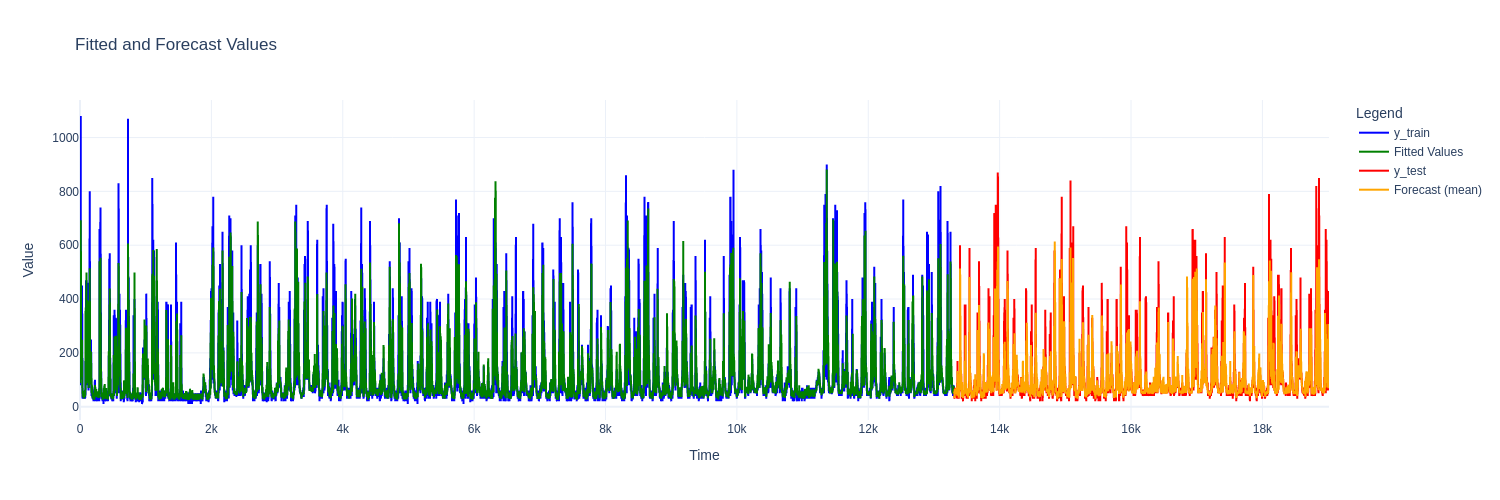

In [59]:
import plotly.graph_objects as go

# Extracting data
fitted_values = train_pred
mean_forecast = test_pred
# lo_95 = forecast_ets['lo-95']
# hi_95 = forecast_ets['hi-95']

# Define time indices for training and test data
train_indices = list(range(len(y_train)))
test_indices = list(range(len(y_train), len(y_train) + len(y_test)))

# Create traces
fig = go.Figure()

# Plot the true y_train values
fig.add_trace(go.Scatter(x=train_indices, y=y_train, mode='lines', name='y_train', line=dict(color='blue')))

# Plot the fitted values for y_train
fig.add_trace(go.Scatter(x=train_indices, y=fitted_values, mode='lines', name='Fitted Values', line=dict(color='green')))

# Plot the true y_test values
fig.add_trace(go.Scatter(x=test_indices, y=y_test, mode='lines', name='y_test', line=dict(color='red')))

# Plot the mean forecast values for y_test
fig.add_trace(go.Scatter(x=test_indices, y=mean_forecast, mode='lines', name='Forecast (mean)', line=dict(color='orange')))

# Plot the confidence intervals (lo-95 and hi-95)
# fig.add_trace(go.Scatter(x=test_indices, y=lo_95, fill=None, mode='lines', name='Lower Bound (95%)', line=dict(color='gray', dash='dash')))
# fig.add_trace(go.Scatter(x=test_indices, y=hi_95, fill='tonexty', mode='lines', name='Upper Bound (95%)', line=dict(color='gray', dash='dash')))

# Update layout
fig.update_layout(
    title="Fitted and Forecast Values",
    xaxis_title="Time",
    yaxis_title="Value",
    legend_title="Legend",
    template="plotly_white",
    height=500, width=1500
)

# Show the plot
# fig.show()
fig.show("png")

#### The XGBoost model performed better than ETS, particularly in capturing the high peaks. However, we should aim to find a model that can further improve in modeling these higher peaks and also allow us to predict the confidence interval.

In [25]:
from xgboost import plot_importance
from matplotlib import pyplot

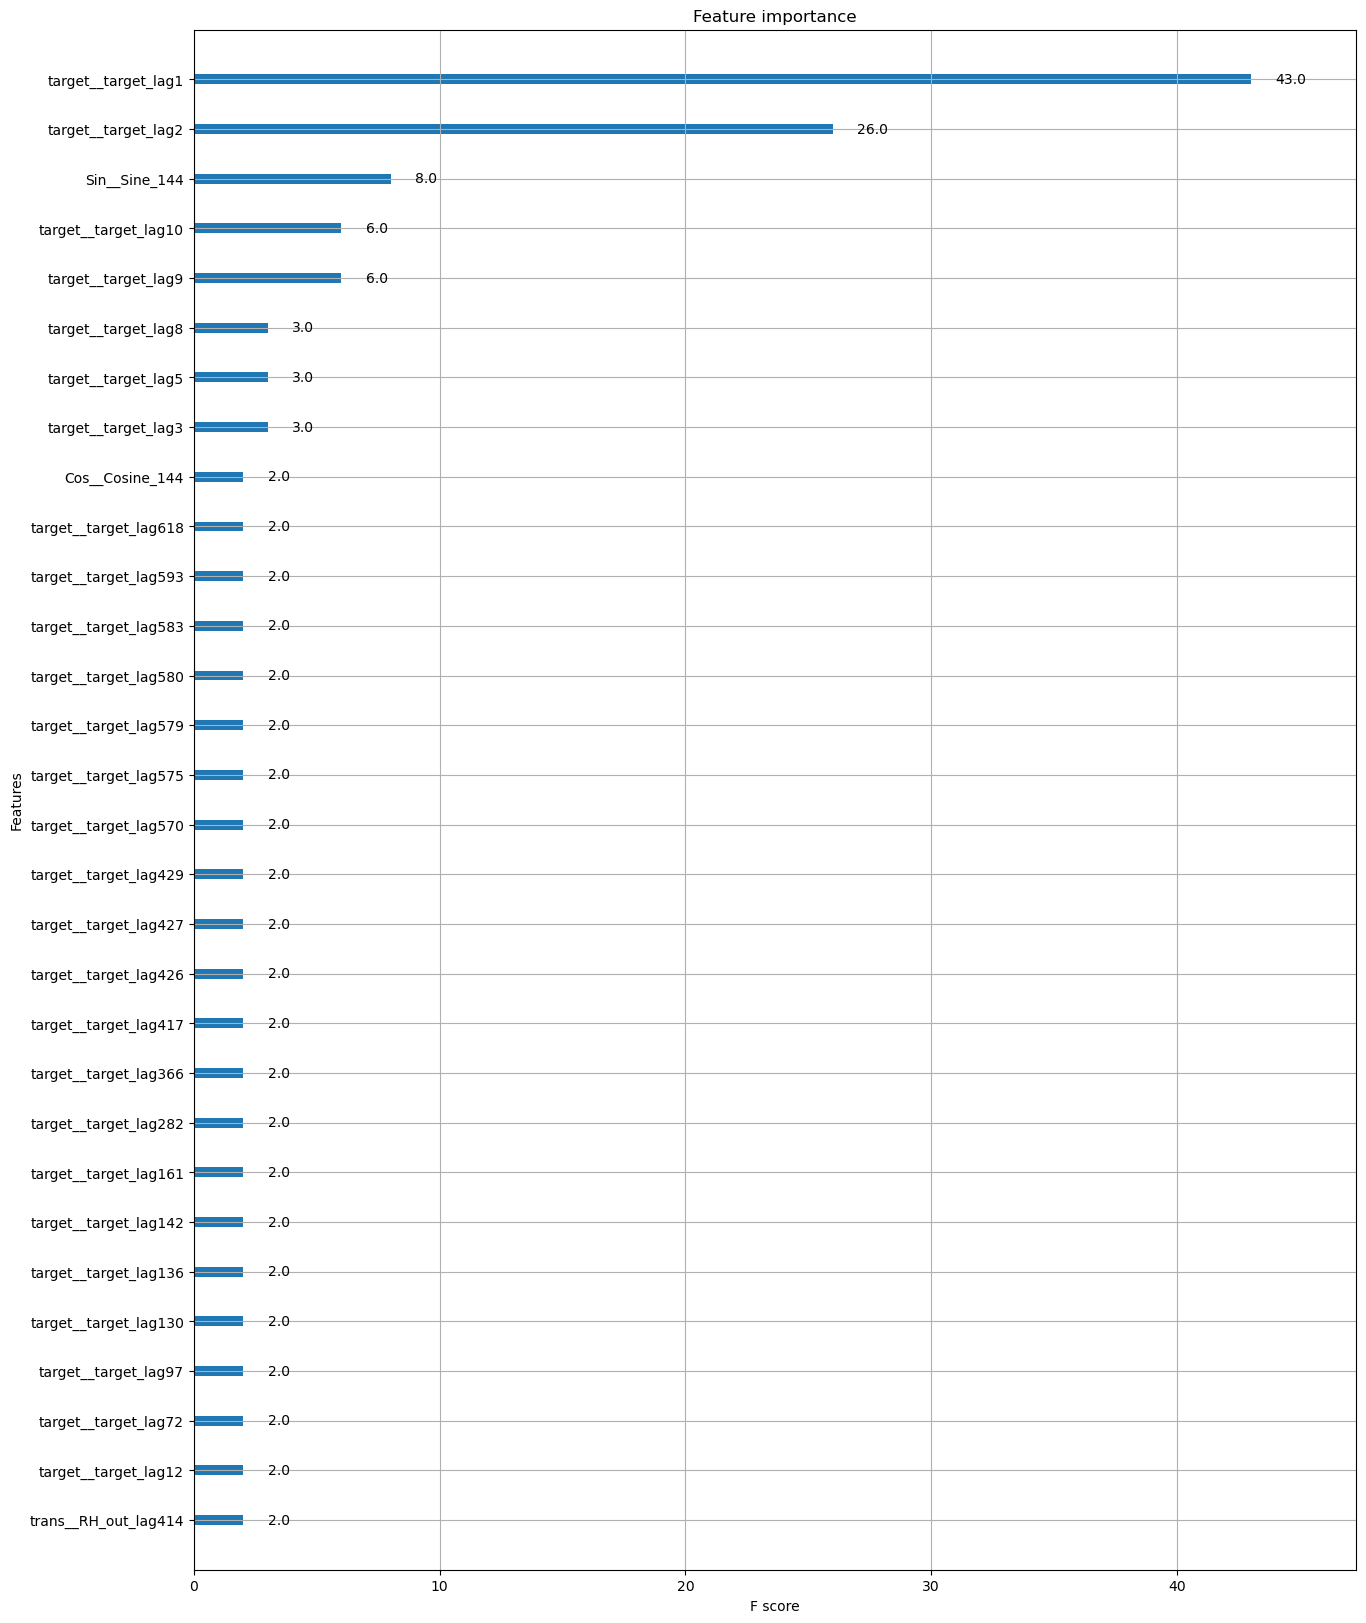

In [26]:
fig, ax = plt.subplots(figsize=(15, 20))
xgb.plot_importance(model, ax=ax, max_num_features = 30)
plt.show()